## Importing the Libraries

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import random

### Using Transfer Learning with MobileNetV2

In [17]:
from tensorflow.keras.applications import MobileNetV2

## Defining Training Images

In [18]:
img_height =160
img_width = 160
batch_size = 32
nb_epochs = 50 # Validation reaches stability by epoch 37

In [19]:
TRAINING_DIR = "105_classes_pins_dataset"

train_datagen = ImageDataGenerator(
                rescale=1/255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                rotation_range=40,
                width_shift_range=0.1,
                height_shift_range=0.1,
                validation_split=0.2)

train_set = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

Found 14071 images belonging to 105 classes.


## Defining Validation Images

In [20]:
validation_set = train_datagen.flow_from_directory(
    TRAINING_DIR, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 3463 images belonging to 105 classes.


## Designing Model

In [21]:
trained_model=MobileNetV2(input_shape=(img_height,img_width,3),           
                    include_top=False,
                    weights='imagenet')   
# Not including top layer as we only have 105 classes, using imagenet tournament weights for mobilenet


trained_model.trainable=True  #Un-Freeze all the pretrained layers of MobileNetV2 for Training.
    
trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Adding Custom Layers

In [22]:
last_layer=trained_model.get_layer('out_relu') # Storing mobilenet last layer
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.

In [23]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(105,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

## Fitting on Model

In [24]:
history = model.fit(train_set,
                    steps_per_epoch = train_set.samples // batch_size,
                    validation_data = validation_set, 
                    validation_steps = validation_set.samples // batch_size,
                    epochs = nb_epochs,
                    verbose=1)

Epoch 1/50
439/439 [==============================] - 100s 228ms/step - loss: 4.9797 - accuracy: 0.0149 - val_loss: 4.6750 - val_accuracy: 0.0249
Epoch 2/50
439/439 [==============================] - 104s 237ms/step - loss: 4.5173 - accuracy: 0.0301 - val_loss: 4.3323 - val_accuracy: 0.0489
Epoch 3/50
439/439 [==============================] - 95s 216ms/step - loss: 4.2100 - accuracy: 0.0594 - val_loss: 3.7507 - val_accuracy: 0.1163
Epoch 4/50
439/439 [==============================] - 96s 218ms/step - loss: 3.7845 - accuracy: 0.1093 - val_loss: 3.3707 - val_accuracy: 0.2020
Epoch 5/50
439/439 [==============================] - 91s 208ms/step - loss: 3.3450 - accuracy: 0.1806 - val_loss: 3.0528 - val_accuracy: 0.2407
Epoch 6/50
439/439 [==============================] - 93s 211ms/step - loss: 2.9442 - accuracy: 0.2567 - val_loss: 2.7773 - val_accuracy: 0.2960
Epoch 7/50
439/439 [==============================] - 88s 201ms/step - loss: 2.5306 - accuracy: 0.3448 - val_loss: 2.4631 - val_

## Saving Model for future use

In [25]:
# Save the model as model.h5
model.save('MobileNetV2_3.h5')

## Plotting the result

In [26]:
# Load the model
model1 = tf.keras.models.load_model('MobileNetV2_3.h5')

Text(0.5, 1.0, 'Training and validation loss')

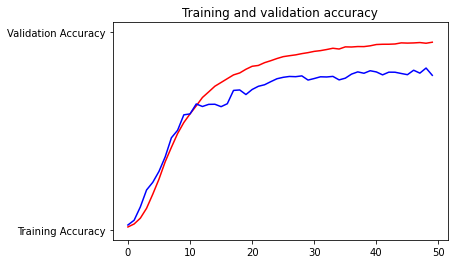

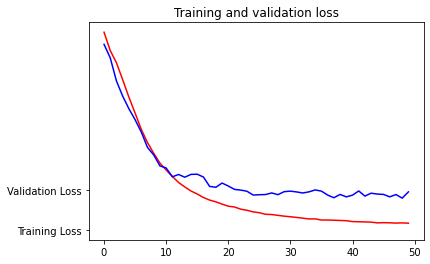

In [27]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

## Evaluating accuracy

In [28]:
STEP_SIZE_TEST = validation_set.samples // batch_size
loss, acc = model.evaluate_generator(generator=validation_set, steps=STEP_SIZE_TEST)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [29]:
print('The model has accuracy of: {:.4} %'.format(acc*100))

The model has accuracy of: 77.75 %
